### Logistic Regression
Baseline model to get a sense of what kind of accuracy we get initially.

In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [29]:
train = pd.read_csv("train_reduced_probs.csv", low_memory = False)
test = pd.read_csv("test_reduced_probs.csv", low_memory = False)

train_id = train['id']
test_id = test['id']
del train['id']
del test['id']

display(train.head())
display(test.head())

,Unnamed: 0,Predicted_LGBM,Predicted_XGB,Predicted_RF,Predicted_LogReg,satisfied
0,0,0.193412,0.237400,0.055093,0.535238,0
1,1,0.024508,0.246444,0.029583,0.449595,0
2,2,0.963198,0.779915,0.981759,0.545411,1
3,3,0.539349,0.516952,0.538981,0.474055,0
4,4,0.875736,0.738075,0.820556,0.569780,1


,Unnamed: 0,Predicted_LGBM,Predicted_XGB,Predicted_RF,Predicted_LogReg
0,0,0.088561,0.234587,0.278148,0.521358
1,1,0.092558,0.334485,0.261167,0.458773
2,2,0.939786,0.739908,0.718611,0.460207
3,3,0.833570,0.737796,0.562407,0.545818
4,4,0.628864,0.516952,0.470833,0.486995


In [3]:
train['satisfied'].value_counts()

1    15626
0    14454
Name: satisfied, dtype: int64

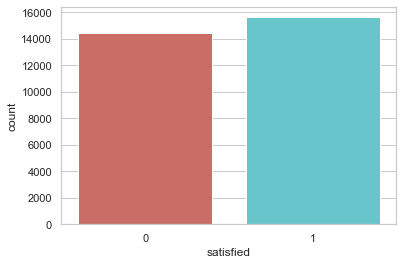

In [4]:
sns.countplot(x='satisfied', data=train, palette='hls')
plt.show()

In [5]:
print("percentage of not satisfied is", (len(train[train['satisfied']==0]) / train.shape[0])*100)
print("percentage of satisfied is", (len(train[train['satisfied']==1]) / train.shape[0])*100)

percentage of not satisfied is 48.05186170212766
percentage of satisfied is 51.94813829787234


In [30]:
X_cols = list(train.columns[1:])
X_cols.remove('satisfied')
X = train.loc[:, X_cols]
y = train.loc[:, train.columns == 'satisfied']


display(X)
display(y)

,Predicted_LGBM,Predicted_XGB,Predicted_RF,Predicted_LogReg
0,0.193412,0.237400,0.055093,0.535238
1,0.024508,0.246444,0.029583,0.449595
2,0.963198,0.779915,0.981759,0.545411
3,0.539349,0.516952,0.538981,0.474055
4,0.875736,0.738075,0.820556,0.569780
...,...,...,...,...
30074,0.284707,0.247027,0.863426,0.326967
30075,0.332747,0.319935,0.854444,0.512218
30076,0.079406,0.230393,0.029979,0.361376
30077,0.796712,0.589118,0.936497,0.332995


,satisfied
0,0
1,0
2,1
3,0
4,1
...,...
30074,1
30075,1
30076,0
30077,1


In [31]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 3096)

In [32]:
y['satisfied'].value_counts()

1    15626
0    14453
Name: satisfied, dtype: int64

In [33]:
logit_model = sm.Logit(y,X)
result = logit_model.fit()
print(result.summary2())


Optimization terminated successfully.
         Current function value: 0.152637
         Iterations 9
                         Results: Logit
Model:               Logit            Pseudo R-squared: 0.780    
Dependent Variable:  satisfied        AIC:              9190.3285
Date:                2020-03-10 22:14 BIC:              9223.5748
No. Observations:    30079            Log-Likelihood:   -4591.2  
Df Model:            3                LL-Null:          -20826.  
Df Residuals:        30075            LLR p-value:      0.0000   
Converged:           1.0000           Scale:            1.0000   
No. Iterations:      9.0000                                      
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Predicted_LGBM    2.6023   0.2726   9.5476 0.0000  2.0681  3.1365
Predicted_XGB    -6.7419   0.3359 -20.0739 0.0000 -7.4002 -6.0837


In [34]:
y = y['satisfied']

In [35]:
full_log_model = LogisticRegression()
full_log_model.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
expected_y = y_test
predicted_y = full_log_model.predict(X_test)


# Summarize model fit
print(); print(metrics.classification_report(expected_y, predicted_y))
print(); print(metrics.confusion_matrix(expected_y, predicted_y))
print(); print(metrics.roc_auc_score(expected_y, predicted_y))


              precision    recall  f1-score   support

           0       0.80      0.78      0.79      2824
           1       0.81      0.83      0.82      3192

    accuracy                           0.80      6016
   macro avg       0.80      0.80      0.80      6016
weighted avg       0.80      0.80      0.80      6016


[[2194  630]
 [ 551 2641]]

0.8021465668420342


In [37]:
X_final_test = test.loc[:, X_cols]
y_pred_full_log_model = full_log_model.predict(X_final_test)
probs = full_log_model.predict_proba(X_final_test)
z = [row[1] for row in probs]
test_ids = test_id
test_pred_full_log_model = pd.DataFrame({'id': test_ids, 'Predicted_LogReg':z})
test_pred_full_log_model

,id,Predicted_LogReg
0,14061,0.109750
1,16467,0.105844
2,25725,0.873123
3,9100,0.564131
4,32597,0.358459
...,...,...
9240,31430,0.913646
9241,3876,0.421054
9242,20710,0.928145
9243,26015,0.731316


In [39]:
y_pred_full_log_model_train = full_log_model.predict(X)
probs = full_log_model.predict_proba(X)
z = [row[1] for row in probs]
test_ids = train_id
train_pred_full_log_model = pd.DataFrame({'id': test_ids, 'Predicted_LogReg':z})
train_pred_full_log_model

,id,Predicted_LogReg
0,9948,0.007669
1,25601,0.008605
2,8592,0.992380
3,29593,0.594437
4,4252,0.957682
...,...,...
30074,34440,0.988357
30075,13566,0.984555
30076,29824,0.008299
30077,9573,0.990618


In [40]:
test_pred_full_log_model.to_csv("test_logreg_reduced_stack.csv", index=False)
train_pred_full_log_model.to_csv("train_logreg_reduced_stack.csv", index=False)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
model = LogisticRegression()
model.fit(X_train,y_train)
score = model.score(X_test,y_test)
print(score)

In [ ]:
X_train_FE, X_test_FE, y_train_FE, y_test_FE = train_test_split(X_FE,y_FE, test_size = 0.3, random_state = 0)
model_FE = LogisticRegression()
model_FE.fit(X_train_FE,y_train_FE)
score = model_FE.score(X_test_FE,y_test_FE)
print(score)

^ logistic regression on FE dataset performs worse, not worth finding reduced model


With the initial logistic regression model that used all features (200 columns) we have a score of

### Recursive Feature Elimination

https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.



In [ ]:
# Find optimum number of features, for which the accuracy is the highest from RFE
high_score = 0

# Variable to store the optimum features
nof = 1
score_list = []

for n in range(1,len(X_cols)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LogisticRegression()
    rfe = RFE(model,n)
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = n
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

In [ ]:
logreg = LogisticRegression()
rfe = RFE(logreg, nof)
rfe = rfe.fit(X, y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

In [ ]:
temp = pd.Series(rfe.support_, index = X_cols)
selected_features_rfe = temp[temp==True].index
selected_features_rfe

In [ ]:
X_reduced = X[selected_features_rfe]
reduced_log_model = LogisticRegression()
reduced_log_model.fit(X_reduced,y)

In [ ]:
X_test_reduced = test.loc[:, selected_features_rfe]
y_pred_reduced_log_model = reduced_log_model.predict(X_test_reduced)
test_pred_reduced_log_model = pd.DataFrame({'id': test_ids, 'Predicted':y_pred_reduced_log_model})
test_pred_reduced_log_model

In [ ]:
test_pred_reduced_log_model.to_csv("test_pred_reduced_log_model.csv", index=False)